In [1]:
from pyspark import SparkContext
import datetime
from csv import reader
import pandas            as pd
import numpy             as np
import matplotlib
import matplotlib.pyplot as plt
import sys #only needed to determine Python version number
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
sc = SparkContext()
# use dataclean.py from here to clean data
filepath    = r'./NYPD_Complaint_Data_Historic.csv'
df = sc.textFile(filepath).map(lambda l: reader([l]).__next__())

header = df.first() # csv header

df = df.filter(lambda line: line != header).cache() # filter out header

In [3]:
def transform(array):
    array[1] = datetime.datetime.strptime(array[1], '%m/%d/%Y')
    return array

#replace year 1015
def replaceYear2015to2015(array):
    array[1] = array[1].replace('1015', '2015')
    return array

t = df \
    .filter(lambda array: array[1] != '') \
    .map(replaceYear2015to2015) \
    .map(transform) \
    .filter(lambda array: (array[1].year >= 2006 and array[1].year <= 2015))

In [4]:
def setSameYear(x):
    x[1] = x[1].replace(year=2000)
    return (x[1],1)

dateCount = t \
    .map(setSameYear) \
    .reduceByKey(lambda x, y: x + y) \
    .sortByKey() \
    .map(lambda x: (str(x[0].month) + '/' + str(x[0].day), x[1]))

In [5]:
dateCount.count()

366

In [6]:
date = dateCount.collect()
dateTimeList = np.array(date)[:, 0]
count = np.array(date)[:, 1].astype(int)
dateRange = np.arange(len(dateTimeList))

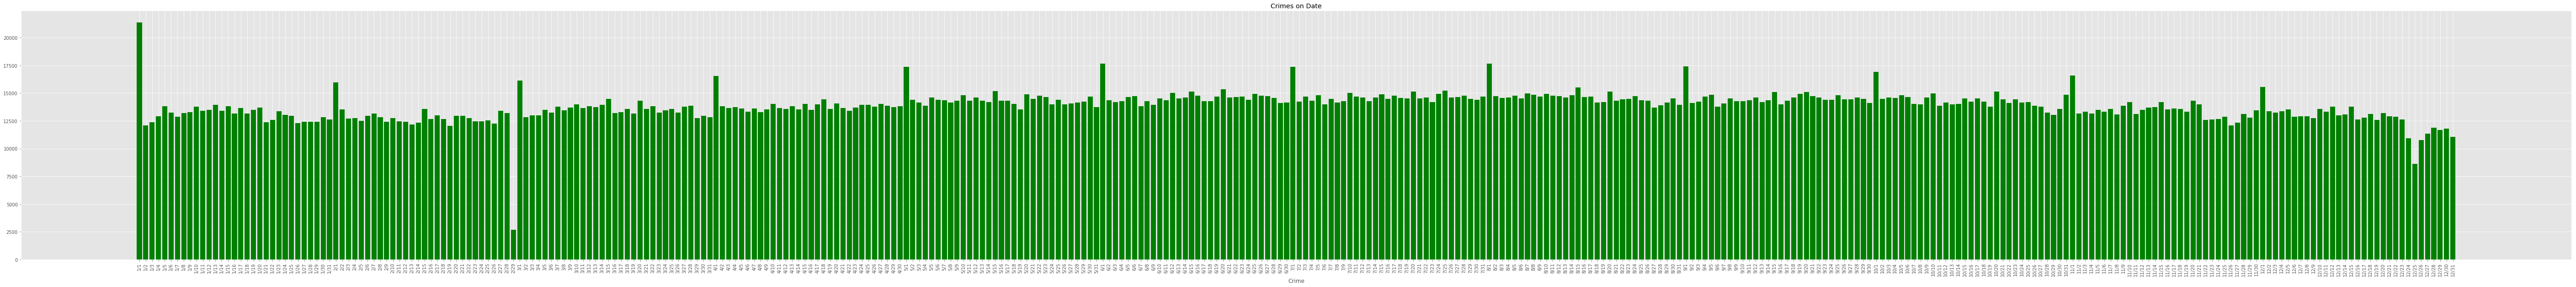

In [7]:
fig, ax = plt.subplots()
ax.bar(dateRange, count, align='center',
        color='green', ecolor='black')
ax.set_xticks(dateRange)
ax.set_xticklabels(dateTimeList, rotation='vertical')
ax.set_xlabel('Crime')
ax.set_title('Crimes on Date')
fig.set_size_inches(100,10)

In [8]:
sc.stop()